# Project 3: Real-time Face Recognition using the SVD

Rivka Shapiro, Juju Ren, Siddanta K C

## Project Description

The goal of this project is to develop a real-time system for face recognition
using dimensionality reduction techniques. The cost (in terms of time and
memory) to identify a face is greatly reduced by representing face images in
a reduced subspace (called the “face space”), instead of using the original
“image space” of m × n pixels.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import shutil 
import os
from PIL import Image
from os import path
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.linalg import svd
from numpy.linalg import matrix_rank


## Activity 1
The database contains 165 GIF images of 15 subjects (subject01, 
subject02, etc.).  There are 11 images per subject.

In [3]:
source = r'yaledatabase/'
dest = r'Train/'
classes = ["%.2d" % i for i in range(1,16)] # build 15 subfolders to store images( 01, 02, ..., 15)
for dir in os.listdir(source):
    inpath = os.path.join(source, dir)
    for i in range(len(classes)):
        item = classes[i]
        j = str(i+1)
        destine= os.path.join(dest,j)
        if item in dir: # locate the image
            shutil.copy(inpath, destine) # copy images to the subfolder 
# we separated all the data into 15 subfolders under folder 'Train' and the face id number(1-15)

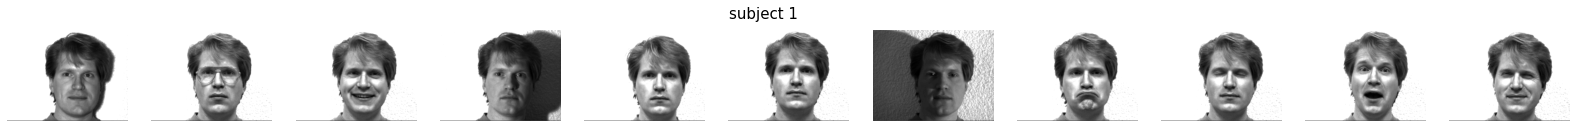

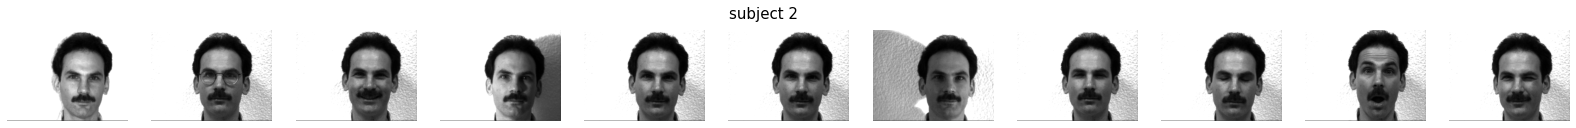

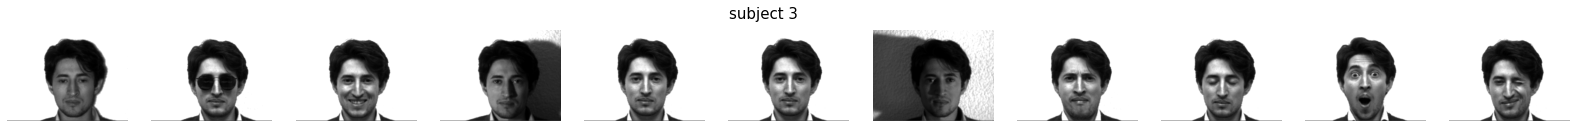

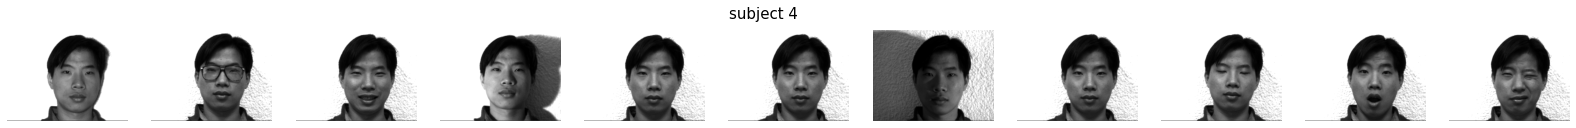

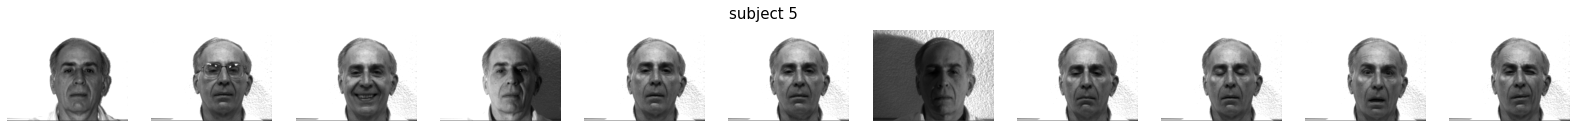

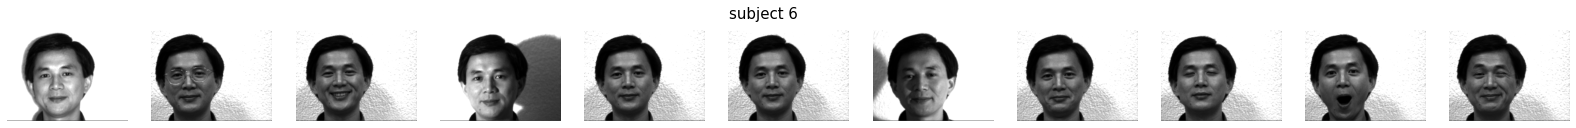

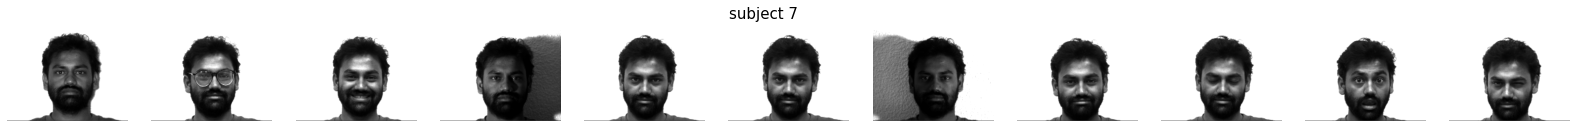

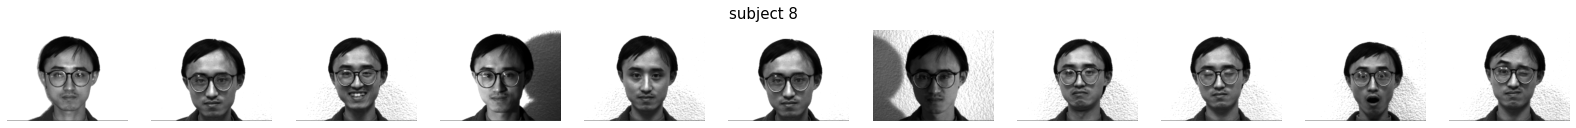

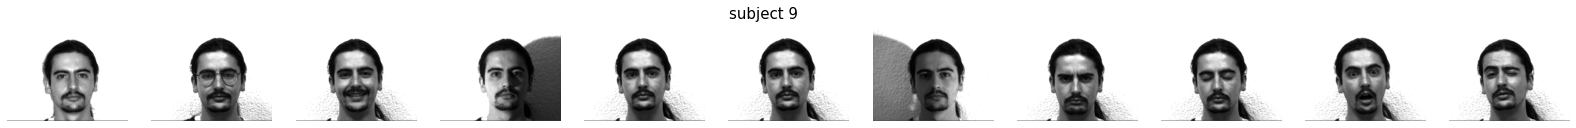

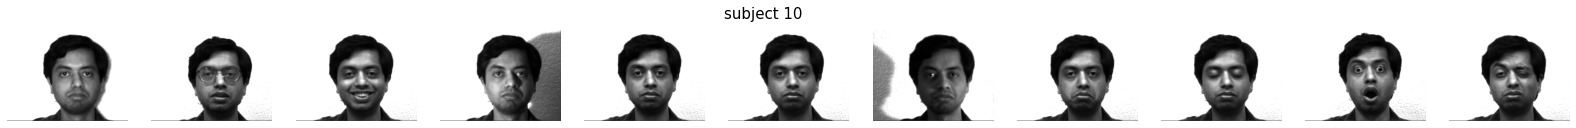

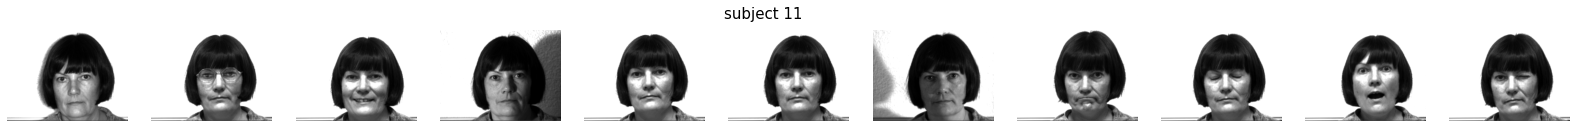

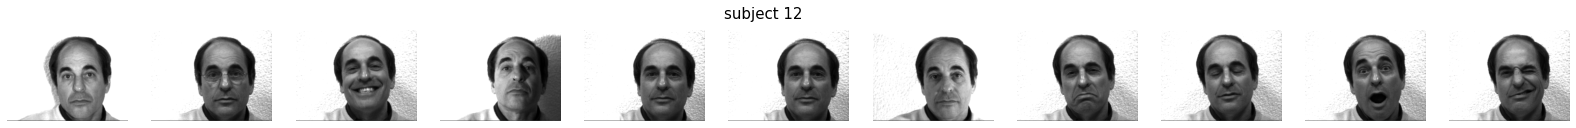

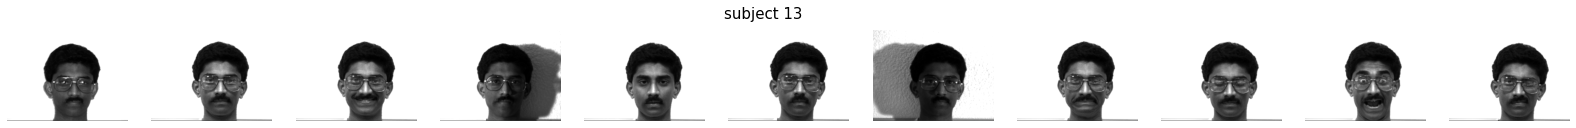

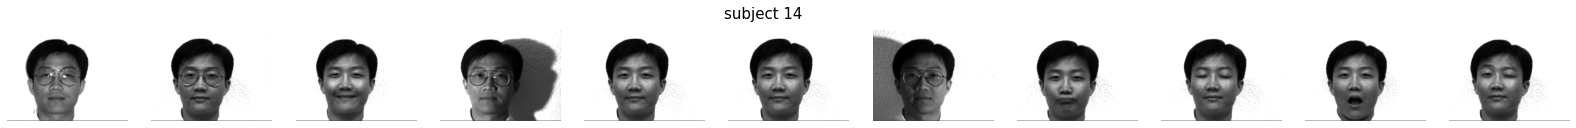

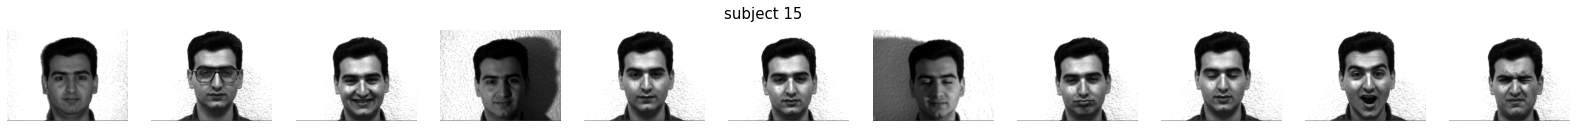

<Figure size 2016x144 with 0 Axes>

In [4]:
# show images from subfolders
# show n figures of each subject
n = 11   # 1<=n<=11
img_path=[] # create a list for all image paths
data_label =[]
for dir in sorted(os.listdir(dest), key=len):# print the iamges in order of the subfolders: 1, 2, 3,..., 15
    path = dest + dir
    fig = plt.figure(figsize = (28,2))
    fig.suptitle('subject '+ dir,fontsize=15)
    for i in range(len(os.listdir(path))):
        path_ = path+ "/" + os.listdir(path)[i]
        img_path.append(path_) # append all images path to img_path
        data_label.append('subject'+ dir)
        img_ = plt.imread(path_)
        plt.subplot(1,n,i+1)
        plt.axis("off")
        plt.imshow(img_, cmap = 'gray')

In [5]:
len(img_path)

165

In [6]:
len(data_label)

165

## Activity 2

Write a function img2vec that given an image of 243 × 320 pixels,
converts it to a 1-dimensional array of size m = 77760 = 243 × 320
of real values. Write a function vec2img that performs the reverse
operation: converts an array to an image which can then be displayed.
Convert all faces to vectors and store them as columns of an m × n
matrix, which we will call the dataset

face image of w × h pixels\
w = 243\
h = 320
- define function img2vec

In [7]:
def img2vec(img, x, y):
    img.resize((x, y))
    a = np.asarray(img)
    array =a.flatten()
    return array

In [8]:
# test with the first image
img = Image.open(img_path[0])
array = img2vec(img, 243,320)
array.shape

(77760,)

- define function vec2img

In [9]:
def vec2img(array, x,y):
    img=np.reshape(array, (x, y)) # converts an array to an image which can then be displayed
    return img

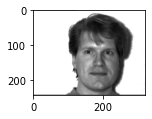

In [10]:
# test with the first image-array
img = vec2img(array,243,320)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap = 'gray')
plt.show()

-  Convert all faces to vectors and store them as columns of an m × n matrix\
m = 165\
n = 77760

In [11]:
#create a list of arrays
arrays=[]
for path in img_path:
    img = Image.open(path)
    array = img2vec(img, 243,320)
    arrays.append(array)
# convert a list of arrays into the matrix
dataset=np.vstack(arrays)
dataset.shape

(165, 77760)

 Dataset F\
 F = [f1, f2, . . . , fn] of n known faces, n = 165\
 belong to 15 identities

- calculate f-mean from all dataset

In [12]:
f_mean = dataset.mean(0)

- plot f-mean

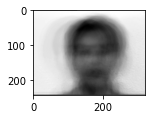

In [13]:
img = vec2img(f_mean, 243, 320)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap = 'gray')
plt.show()

- Normalize the dataset by substracting the mean face to each face in the dataset.


In [14]:
norm_dataset = dataset-f_mean
norm_dataset.shape

(165, 77760)

## Activity 3
Divide the dataset into two disjoint sets\
a set of known faces (which we call the database F) 6/11\
a set of unknown faces (which we call the query set Q) 5/11

In [15]:
def splitdata(dataset):
    data = dataset.copy()
    identity = np.split(data, 15)
    trainarray =[]
    testarray=[]

    for face in identity:
        s1 = np.random.choice(range(face.shape[0]), 6, replace=False)
        s2= [*(set(range(face.shape[0])) - set(s1))]
        train = face[s1,:]
        trainarray.append(train)    
        test = face[s2,:]
        testarray.append(test)

    traindata = np.vstack(trainarray)
    testdata = np.vstack(testarray)
    return traindata, testdata

In [16]:
traindata, testdata = splitdata(norm_dataset)

In [17]:
traindata.shape

(90, 77760)

In [18]:
testdata.shape

(75, 77760)

In [19]:

trainlabel=[]
testlabel=[]
datalabel = np.split(np.array(data_label), 15)

for l in datalabel:
    l1 = np.random.choice(l, 6, replace=False).tolist()
    l2= np.random.choice(l, 5, replace=False).tolist()
    trainlabel.append(l1)
    testlabel.append(l2)
    
trainlabel = [item for sublist in trainlabel for item in sublist]
testlabel = [item for sublist in testlabel for item in sublist]

In [20]:
len(trainlabel)

90

In [21]:
len(testlabel)

75

## Activiey 4 
perform face recognition in the original image space

In [22]:
def id_query(img_array, database):
    distance = []
    for data in database:
        epsilon = np.linalg.norm(data-img_array)
        distance.append(epsilon)
    # locate the position in the list of the minimum distance
    minpos = distance.index(min(distance))
    # return the face id
    id = trainlabel[minpos]
    return id

In [23]:
def testTrain(test, train):
    # test 20 random data
    test_num = 20
    # generate a random list choosing 20 data from test dataset
    list = random.sample(range(0, len(testlabel)), test_num)
    count =0
    for i in list:
        correct = testlabel[i]
        predict = id_query(test[i], train)
        if predict == correct:
            count+=1
            print(True, 'test label:',correct,'predict label:',predict)
        else:
            print(False, 'test label:',correct,'predict label:',predict)
    print('accuracy =', count/test_num)
    
testTrain(testdata, traindata)

True test label: subject14 predict label: subject14
False test label: subject9 predict label: subject7
True test label: subject7 predict label: subject7
True test label: subject9 predict label: subject9
True test label: subject6 predict label: subject6
False test label: subject13 predict label: subject7
True test label: subject10 predict label: subject10
True test label: subject4 predict label: subject4
True test label: subject12 predict label: subject12
False test label: subject6 predict label: subject14
True test label: subject9 predict label: subject9
True test label: subject15 predict label: subject15
False test label: subject4 predict label: subject1
True test label: subject1 predict label: subject1
True test label: subject13 predict label: subject13
True test label: subject11 predict label: subject11
True test label: subject9 predict label: subject9
True test label: subject5 predict label: subject5
True test label: subject5 predict label: subject5
False test label: subject10 pred

## Activity 5

In [24]:
rounds = 30
import time

def accuracytest(rounds, data):
    sumAcc=0
    sumTime=0 
    for i in range(rounds):
        count =0
        traindata, testdata = splitdata(data)
        test_num = len(testlabel)
        start = time.time()
        for j in range(len(testlabel)):
            correct = testlabel[j]
            predict = id_query(testdata[j], traindata)
            if predict == correct:
                count+=1
            else:
                pass
        end = time.time()
        tim = end-start
        acc = count/test_num
        print('rounds ',i, 'accuracy =', acc, 'time = ', tim)
        sumAcc += acc
        sumTime += tim

    print("average accuracy = ", sumAcc/rounds)
    print("average time = ", sumTime/rounds)
    
    

accuracytest(rounds, norm_dataset)


rounds  0 accuracy = 0.7466666666666667 time =  0.643531084060669
rounds  1 accuracy = 0.8 time =  0.6141331195831299
rounds  2 accuracy = 0.8 time =  0.6398487091064453
rounds  3 accuracy = 0.76 time =  0.5839862823486328
rounds  4 accuracy = 0.7733333333333333 time =  0.630638837814331
rounds  5 accuracy = 0.76 time =  0.6031677722930908
rounds  6 accuracy = 0.7333333333333333 time =  0.6021475791931152
rounds  7 accuracy = 0.8133333333333334 time =  0.5835287570953369
rounds  8 accuracy = 0.7733333333333333 time =  0.6107883453369141
rounds  9 accuracy = 0.7733333333333333 time =  0.6565384864807129
rounds  10 accuracy = 0.8 time =  0.617866039276123
rounds  11 accuracy = 0.7866666666666666 time =  0.615288496017456
rounds  12 accuracy = 0.88 time =  0.5763976573944092
rounds  13 accuracy = 0.7066666666666667 time =  0.5991170406341553
rounds  14 accuracy = 0.8266666666666667 time =  0.5486392974853516
rounds  15 accuracy = 0.7733333333333333 time =  0.5649635791778564
rounds  16 ac

## Activity 6
perform recognition in the reduced face space

The face space is spanned by the first columns u1, u2, . . . , up of U

In [25]:
f_mean = dataset.mean(0)
A =[]
for i in range(len(dataset)):
    a = dataset[i]-f_mean
    A.append(a)
A = np.vstack(A).T
A.shape

(77760, 165)

A=[a1, a2,..., aN]\
A is a M x N matrix\
where M = 77760, N = 165\
A = UΣVT\
where U 

In [26]:
U, s, VT = svd(dataset.T, full_matrices=False)

Matrix U is an M × M orthogonal matrix: \
U = [u1, u2, u3, ..., ur, ur+1,..., uM]

Σ is an M × N diagonal matrix

Matrix V is an N × N orthogonal matrix

In [28]:
print('U:',U.shape,'Σ:',s.shape,'V.T:',VT.shape)

U: (77760, 165) Σ: (165,) V.T: (165, 165)


r ≤ N << M\
{ u1, u2, ..., ur } form an orthonormal basis for R(A)\
 Each ui , i = 1,2,...,r , can be called a ‘base-face’. 

In [29]:
p=matrix_rank(dataset)
p

156

In [31]:
# r is a random number smaller than N
basefaces = np.dot(U[0:p,:], dataset)
#basefaces.shape

In [32]:
def makeImgs(basis, x,y):
    fig = plt.figure(figsize = (28,30))
    for i in range(p):
        ui = np.copy(basis[:,i])
        ui = ui*255/np.amax(ui)
        img = vec2img(ui, x,y)
        plt.subplot(15,11,i+1)
        plt.title(i+1)
        plt.axis('off')
        plt.imshow(img,cmap='gray')      

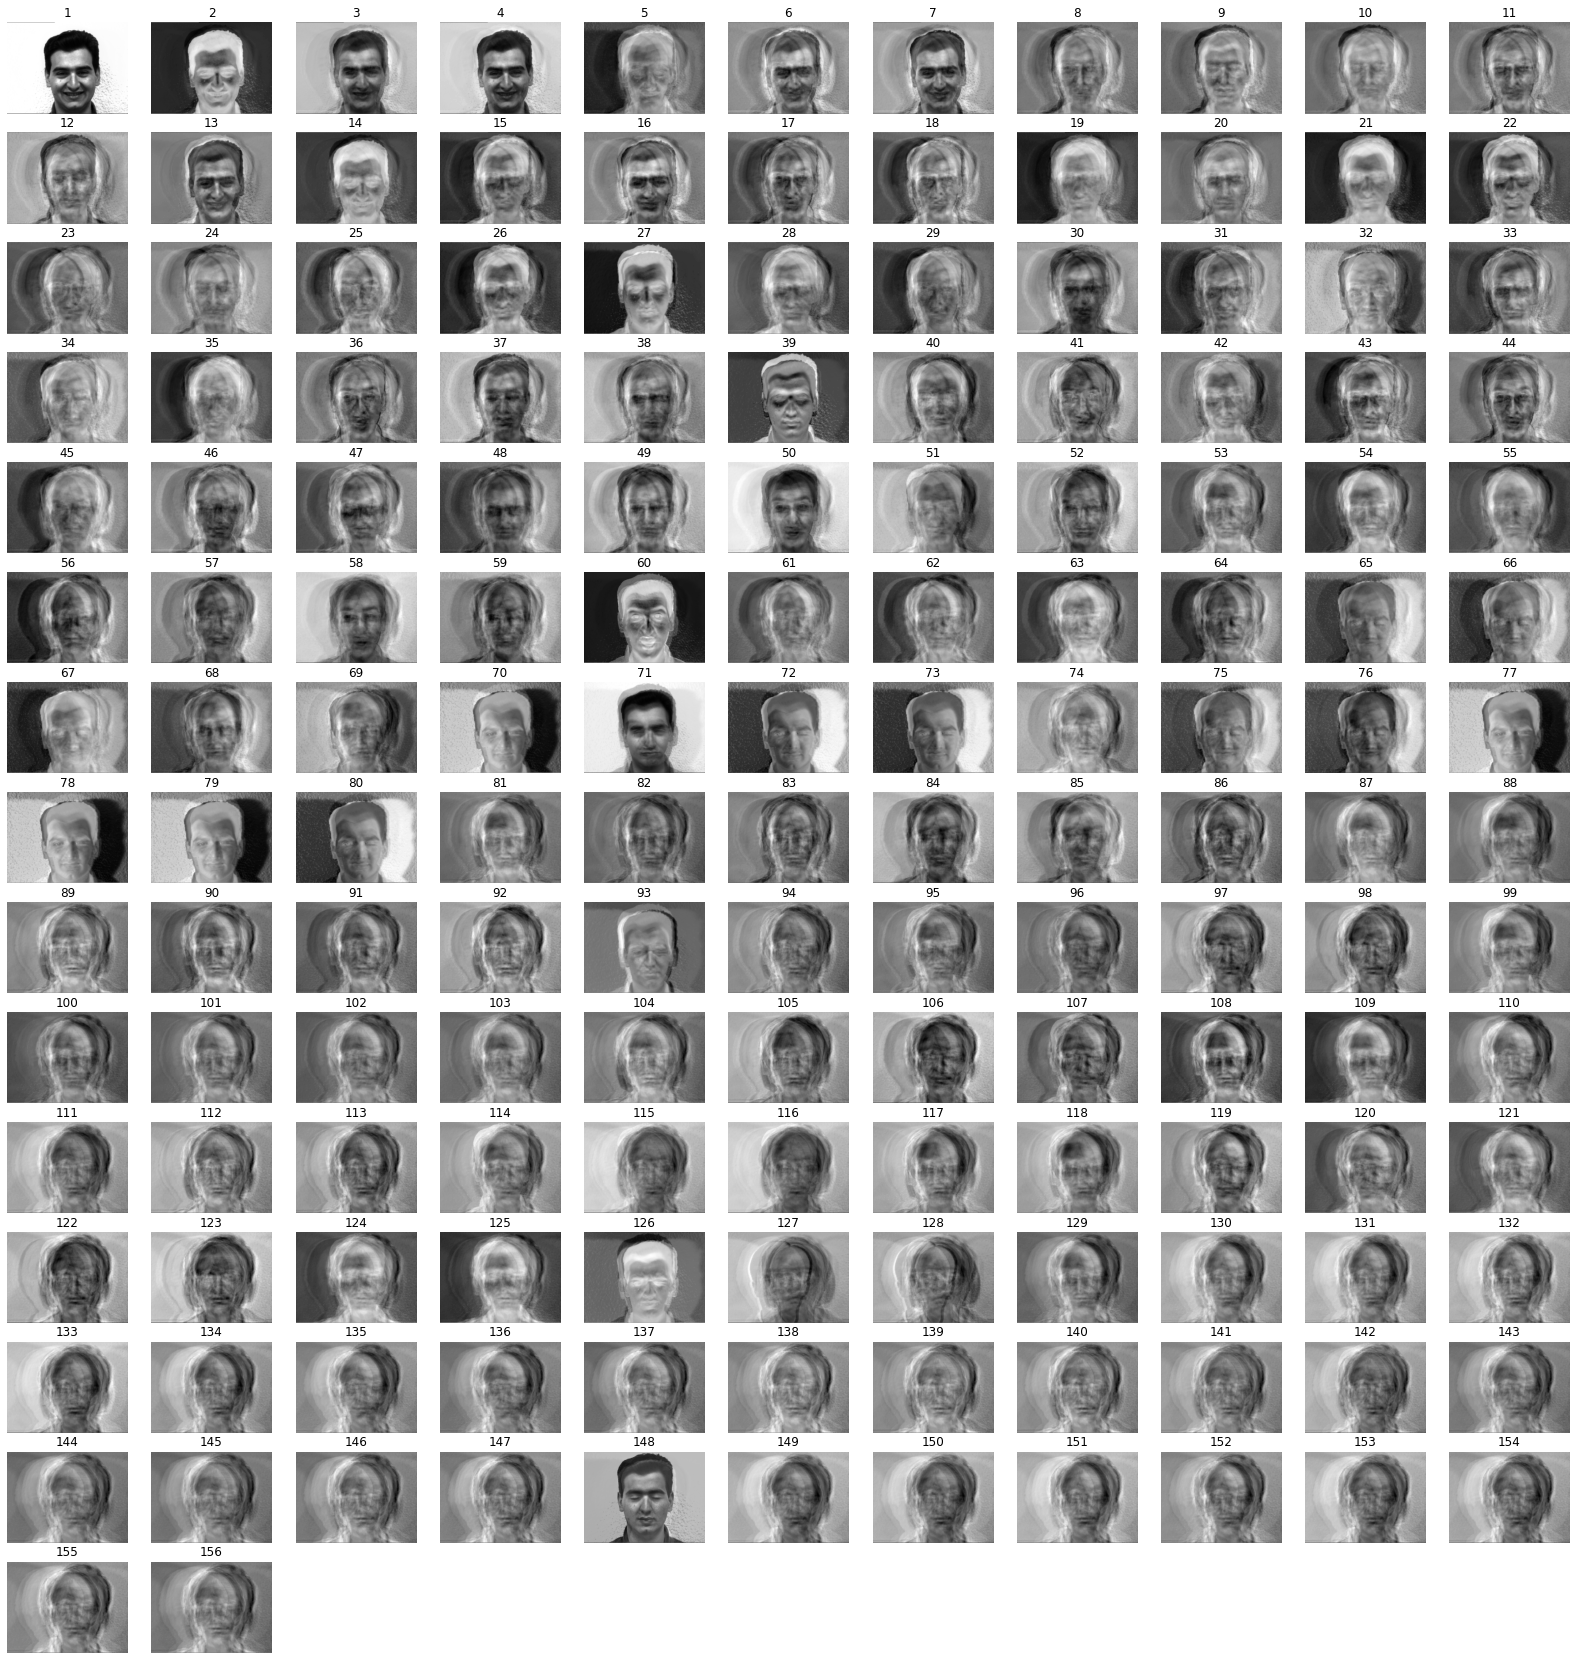

In [33]:
makeImgs(basefaces.T, 243, 320)

## Activity 7

p should follow that p<= N<=M\
where N = 165, M = 77760 in this dataset\
Here we are plotting the values of s to find appropriate value of p

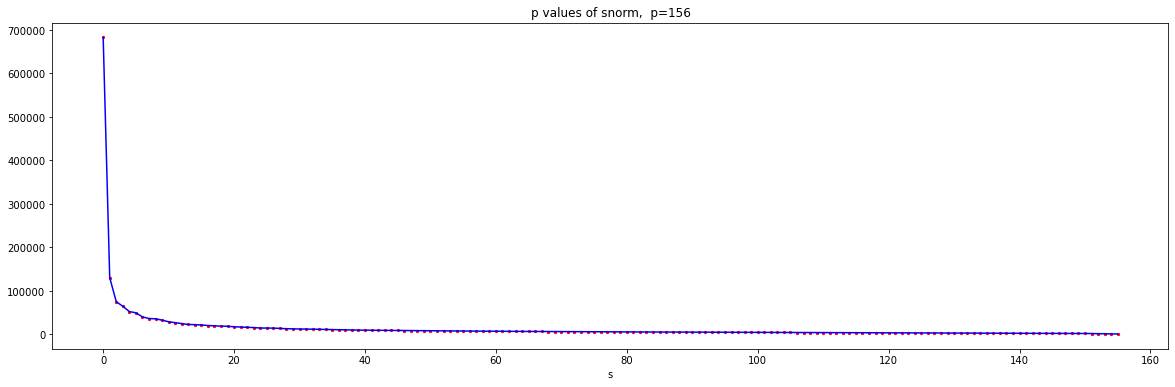

In [35]:
y= s[0:p]
x=[*range(p)]
plt.figure(figsize = (20,6))
plt.plot(x,y,c ='b', linewidth=1.5)
plt.scatter(x,y,c='r', marker='o', s=5)
plt.xlabel("p")
plt.xlabel("s")
plt.title("p values of snorm,  p="+str(p))
plt.show()

the curve seems to plateau at approximately p=40. this is the value we will use for our reduction.

## Activity 8

R(A) is called a ‘face subspace’ in the ‘image space’ of m × n pixels

In [36]:
newp = 40
print(s[newp])

9996.328


In [38]:
sub40 = U.T[0:newp,:].dot(dataset.T)
sub40.shape

(40, 165)

In [39]:
accuracytest(30, sub40.T)

rounds  0 accuracy = 0.8133333333333334 time =  0.04108166694641113
rounds  1 accuracy = 0.8133333333333334 time =  0.024004220962524414
rounds  2 accuracy = 0.8 time =  0.016083240509033203
rounds  3 accuracy = 0.7066666666666667 time =  0.031343936920166016
rounds  4 accuracy = 0.7066666666666667 time =  0.03187727928161621
rounds  5 accuracy = 0.8 time =  0.031170368194580078
rounds  6 accuracy = 0.8 time =  0.03124690055847168
rounds  7 accuracy = 0.8 time =  0.031629323959350586
rounds  8 accuracy = 0.7866666666666666 time =  0.03201031684875488
rounds  9 accuracy = 0.7733333333333333 time =  0.02412247657775879
rounds  10 accuracy = 0.7733333333333333 time =  0.03189969062805176
rounds  11 accuracy = 0.8133333333333334 time =  0.031531572341918945
rounds  12 accuracy = 0.7733333333333333 time =  0.03133130073547363
rounds  13 accuracy = 0.8666666666666667 time =  0.03170037269592285
rounds  14 accuracy = 0.8266666666666667 time =  0.033045053482055664
rounds  15 accuracy = 0.8133

Here we will investigate the effects of the size of P on the accuracy and time.

In [40]:
sub10 = U.T[0:10,:].dot(dataset.T)
sub100 = U.T[0:100,:].dot(dataset.T)

In [41]:
accuracytest(30,sub100.T)

rounds  0 accuracy = 0.8 time =  0.040316104888916016
rounds  1 accuracy = 0.8133333333333334 time =  0.024104833602905273
rounds  2 accuracy = 0.7333333333333333 time =  0.023833036422729492
rounds  3 accuracy = 0.72 time =  0.03116607666015625
rounds  4 accuracy = 0.7333333333333333 time =  0.047249794006347656
rounds  5 accuracy = 0.8533333333333334 time =  0.04787492752075195
rounds  6 accuracy = 0.7866666666666666 time =  0.03268885612487793
rounds  7 accuracy = 0.8266666666666667 time =  0.024300098419189453
rounds  8 accuracy = 0.8533333333333334 time =  0.031253814697265625
rounds  9 accuracy = 0.7466666666666667 time =  0.03298187255859375
rounds  10 accuracy = 0.7466666666666667 time =  0.04563426971435547
rounds  11 accuracy = 0.8266666666666667 time =  0.015941143035888672
rounds  12 accuracy = 0.8 time =  0.03209185600280762
rounds  13 accuracy = 0.7733333333333333 time =  0.03572249412536621
rounds  14 accuracy = 0.8133333333333334 time =  0.039780616760253906
rounds  15 

In [42]:
accuracytest(30,sub10.T)

rounds  0 accuracy = 0.7333333333333333 time =  0.04832267761230469
rounds  1 accuracy = 0.7066666666666667 time =  0.032076120376586914
rounds  2 accuracy = 0.7066666666666667 time =  0.016088485717773438
rounds  3 accuracy = 0.6666666666666666 time =  0.04690957069396973
rounds  4 accuracy = 0.68 time =  0.04686927795410156
rounds  5 accuracy = 0.7733333333333333 time =  0.03737139701843262
rounds  6 accuracy = 0.6666666666666666 time =  0.03140091896057129
rounds  7 accuracy = 0.7733333333333333 time =  0.023998022079467773
rounds  8 accuracy = 0.76 time =  0.047521114349365234
rounds  9 accuracy = 0.8133333333333334 time =  0.031516313552856445
rounds  10 accuracy = 0.7066666666666667 time =  0.039293766021728516
rounds  11 accuracy = 0.72 time =  0.03262901306152344
rounds  12 accuracy = 0.7066666666666667 time =  0.04009270668029785
rounds  13 accuracy = 0.7333333333333333 time =  0.04006338119506836
rounds  14 accuracy = 0.7333333333333333 time =  0.04073834419250488
rounds  15 

## Reference

Guoliang Zeng. Facial recognition with singular value decomposition. In Advances and innovations in
systems, computing sciences and software engineering, pages 145–148. Springer, 2007.
